In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import altair as alt
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
X_pca=pd.read_excel(r"PCA_data.xlsx")
df=pd.read_excel(r'imp_features.xlsx')

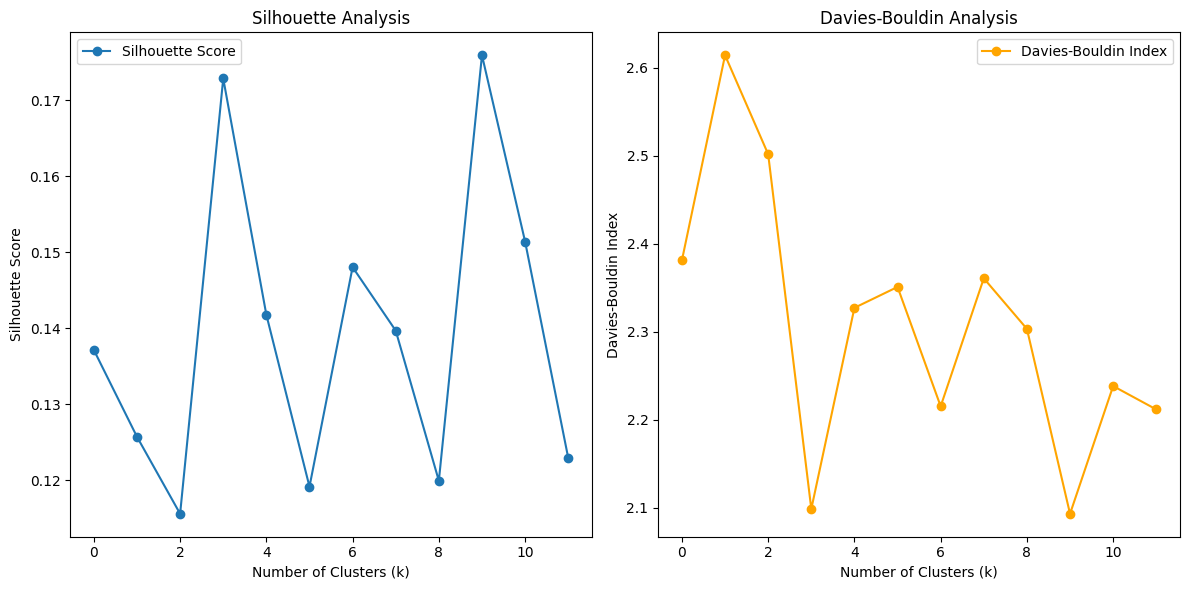

Best model based on BIC:
unique                      [0, 1, 2, 3]
frequency           [372, 1025, 71, 737]
n_components                           4
covariance_type                     full
AIC                         66058.841462
BIC                         69153.117616
CH                            203.773395
Silhouette_Score                0.115611
db_score                        2.501565
index                                  2
Name: 2, dtype: object

Best model based on Silhouette Score:
unique                    [0, 1]
frequency            [977, 1228]
n_components                   2
covariance_type        spherical
AIC                 98058.147567
BIC                 98246.197499
CH                    483.747701
Silhouette_Score         0.17591
db_score                2.092919
index                          9
Name: 9, dtype: object

Best model based on Calinski-Harabasz Index:
unique                    [0, 1]
frequency            [977, 1228]
n_components                   2
covar

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Range of components to test
n_components = range(2, 5)  # Adjust the range as needed
n_number = range(0,36)
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store results
results = []

for cov_type in covariance_types:
    for k in n_components:
        # Fit GMM
        gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
        gmm.fit(X_pca)
        
        # Predict cluster labels
        labels = gmm.predict(X_pca)
        # Calculate metrics
        aic = gmm.aic(X_pca)
        bic = gmm.bic(X_pca)
        sil_score = silhouette_score(X_pca, labels) if k > 1 else np.nan  # Silhouette only valid for k > 1
         # Davies-Bouldin Index (lower is better)
        db_score = davies_bouldin_score(X_pca,labels)
        ch_score = calinski_harabasz_score(X_pca, labels)

        unique, frequency = np.unique(labels, 
                              return_counts = True)
        
        # Store the results
        results.append((unique, frequency,k, cov_type, aic, bic,ch_score, sil_score,db_score))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['unique','frequency','n_components', 'covariance_type', 'AIC', 'BIC', 'CH','Silhouette_Score','db_score'])
results_df['index'] = range(len(results_df))
# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0,12), results_df['Silhouette_Score'], marker='o', label='Silhouette Score')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(range(0,12), results_df['db_score'], marker='o', color='orange', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.tight_layout()
plt.show()

# Find the best model based on BIC or Silhouette
best_model_bic = results_df.loc[results_df['BIC'].idxmin()]
best_model_sil = results_df.loc[results_df['Silhouette_Score'].idxmax()]
best_ch = results_df.loc[results_df['CH'].idxmax()]

print("Best model based on BIC:")
print(best_model_bic)
print("\nBest model based on Silhouette Score:")
print(best_model_sil)
print("\nBest model based on Calinski-Harabasz Index:")
print(best_ch)


In [4]:
Sil_chart = alt.Chart(results_df).mark_line(point=True).encode(
    x=alt.X('index:O', title='Index'),  # Replace 'index' with the correct x-axis column name.
    y=alt.Y('Silhouette_Score:Q', title='Silhouette Score'),
    tooltip=['n_components', 'covariance_type', 'AIC', 'BIC', 'Silhouette_Score', 'db_score']
).properties(
    title='Scree Plot'
).interactive()
db_chart = alt.Chart(results_df).mark_line(point=True).encode(
    x=alt.X('index:O', title='Index'),  # Replace 'index' with the correct x-axis column name.
    y=alt.Y('db_score:Q', title='Silhouette Score'),
    tooltip=['n_components', 'covariance_type', 'AIC', 'BIC', 'Silhouette_Score', 'db_score']
).properties(
    title='Scree Plot'
).interactive()

In [5]:
results_df

,unique,frequency,n_components,covariance_type,AIC,BIC,CH,Silhouette_Score,db_score,index
0,"[0, 1]","[1131, 1074]",2,full,87302.242295,88846.531131,369.123636,0.137149,2.381078,0
1,"[0, 1, 2]","[477, 1057, 671]",3,full,84136.540227,86455.822722,306.435697,0.125736,2.614069,1
2,"[0, 1, 2, 3]","[372, 1025, 71, 737]",4,full,66058.841462,69153.117616,203.773395,0.115611,2.501565,2
3,"[0, 1]","[970, 1235]",2,tied,94278.210002,95138.680903,478.677598,0.172857,2.098415,3
4,"[0, 1, 2]","[502, 1068, 635]",3,tied,93298.783293,94250.429918,354.638410,0.141778,2.326999,4
5,"[0, 1, 2, 3]","[500, 627, 608, 470]",4,tied,93280.670527,94323.492877,304.956002,0.119179,2.350748,5
6,"[0, 1]","[1209, 996]",2,diag,91702.693428,92050.300878,417.073719,0.148047,2.215073,6
7,"[0, 1, 2]","[488, 989, 728]",3,diag,90827.482382,91351.742798,351.554941,0.139696,2.360529,7
8,"[0, 1, 2, 3]","[510, 618, 617, 460]",4,diag,89010.835931,89711.749314,306.406857,0.119949,2.303071,8
9,"[0, 1]","[977, 1228]",2,spherical,98058.147567,98246.197499,483.747701,0.175910,2.092919,9


# **best Silhouette Score**

In [6]:
best_model_sil

unique                    [0, 1]
frequency            [977, 1228]
n_components                   2
covariance_type        spherical
AIC                 98058.147567
BIC                 98246.197499
CH                    483.747701
Silhouette_Score         0.17591
db_score                2.092919
index                          9
Name: 9, dtype: object

In [7]:
# Apply MeanShift clustering
Sil_model = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
sil_labels = Sil_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for GMM is: {silhouette_score(X_pca, sil_labels)}")
print(f"The Davies-Bouldin Index for GMM is: {davies_bouldin_score(X_pca, sil_labels)}")
print(f"The Calinski-Harabasz Index for GMM is: {calinski_harabasz_score(X_pca, sil_labels)}")

The average silhouette score for GMM is: 0.17285683715132455
The Davies-Bouldin Index for GMM is: 2.0984149306660163
The Calinski-Harabasz Index for GMM is: 478.67759758450944


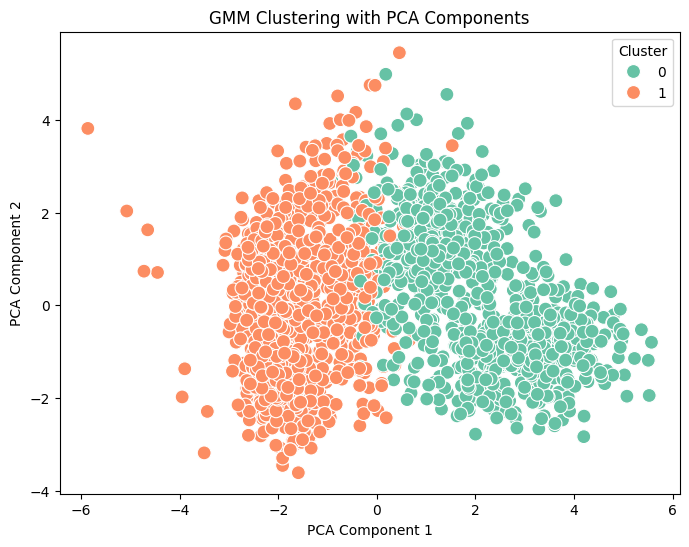

In [8]:
# Visualize the GMM clusters in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=sil_labels, palette='Set2', s=100)

plt.title('GMM Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# **davies bouldin index**

In [9]:
best_model_bic

unique                      [0, 1, 2, 3]
frequency           [372, 1025, 71, 737]
n_components                           4
covariance_type                     full
AIC                         66058.841462
BIC                         69153.117616
CH                            203.773395
Silhouette_Score                0.115611
db_score                        2.501565
index                                  2
Name: 2, dtype: object

In [10]:
# Apply MeanShift clustering
dbi_model = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
dbi_labels = dbi_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for GMM is: {silhouette_score(X_pca, dbi_labels)}")
print(f"The Davies-Bouldin Index for GMM is: {davies_bouldin_score(X_pca, dbi_labels)}")
print(f"The Calinski-Harabasz Index for GMM is: {calinski_harabasz_score(X_pca, dbi_labels)}")

The average silhouette score for GMM is: 0.11561106525927829
The Davies-Bouldin Index for GMM is: 2.501564874774889
The Calinski-Harabasz Index for GMM is: 203.7733946820564


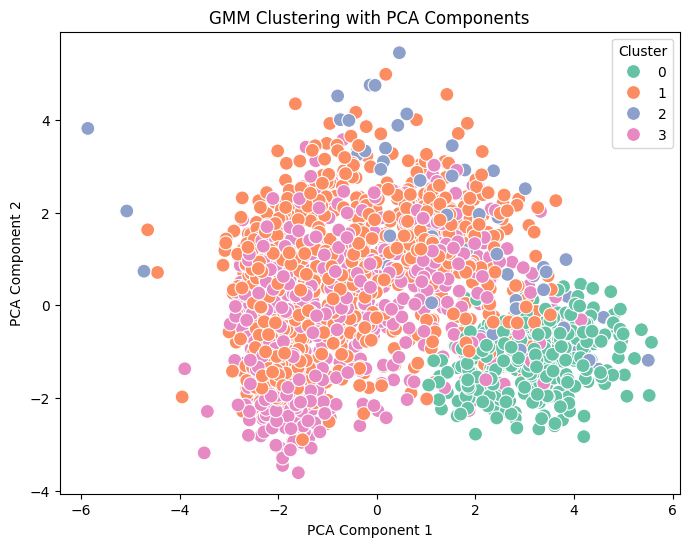

In [11]:
# Visualize the GMM Clustering in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=dbi_labels, palette='Set2', s=100)

plt.title('GMM Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# **calinski_harabasz_index**

In [12]:
best_ch

unique                    [0, 1]
frequency            [977, 1228]
n_components                   2
covariance_type        spherical
AIC                 98058.147567
BIC                 98246.197499
CH                    483.747701
Silhouette_Score         0.17591
db_score                2.092919
index                          9
Name: 9, dtype: object

In [13]:
# Apply GMM clustering
Ch_model = GaussianMixture(n_components=2, covariance_type='tied', random_state=42) 
ch_labels = Ch_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for GMM is: {silhouette_score(X_pca, ch_labels)}")
print(f"The Davies-Bouldin Index for GMM is: {davies_bouldin_score(X_pca, ch_labels)}")
print(f"The Calinski-Harabasz Index for GMM is: {calinski_harabasz_score(X_pca, ch_labels)}")

The average silhouette score for GMM is: 0.17285683715132455
The Davies-Bouldin Index for GMM is: 2.0984149306660163
The Calinski-Harabasz Index for GMM is: 478.67759758450944


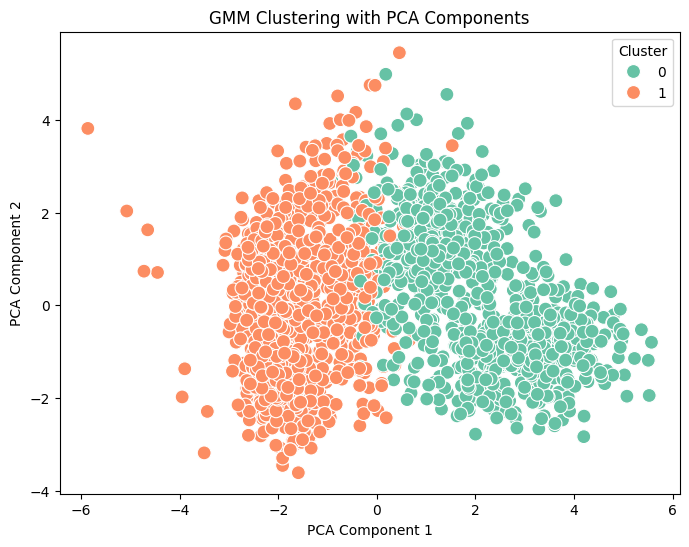

In [14]:
# Visualize the GMM Clustering in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=ch_labels, palette='Set2', s=100)

plt.title('GMM Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

In [15]:
results_df

,unique,frequency,n_components,covariance_type,AIC,BIC,CH,Silhouette_Score,db_score,index
0,"[0, 1]","[1131, 1074]",2,full,87302.242295,88846.531131,369.123636,0.137149,2.381078,0
1,"[0, 1, 2]","[477, 1057, 671]",3,full,84136.540227,86455.822722,306.435697,0.125736,2.614069,1
2,"[0, 1, 2, 3]","[372, 1025, 71, 737]",4,full,66058.841462,69153.117616,203.773395,0.115611,2.501565,2
3,"[0, 1]","[970, 1235]",2,tied,94278.210002,95138.680903,478.677598,0.172857,2.098415,3
4,"[0, 1, 2]","[502, 1068, 635]",3,tied,93298.783293,94250.429918,354.638410,0.141778,2.326999,4
5,"[0, 1, 2, 3]","[500, 627, 608, 470]",4,tied,93280.670527,94323.492877,304.956002,0.119179,2.350748,5
6,"[0, 1]","[1209, 996]",2,diag,91702.693428,92050.300878,417.073719,0.148047,2.215073,6
7,"[0, 1, 2]","[488, 989, 728]",3,diag,90827.482382,91351.742798,351.554941,0.139696,2.360529,7
8,"[0, 1, 2, 3]","[510, 618, 617, 460]",4,diag,89010.835931,89711.749314,306.406857,0.119949,2.303071,8
9,"[0, 1]","[977, 1228]",2,spherical,98058.147567,98246.197499,483.747701,0.175910,2.092919,9


In [16]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3,covariance_type='full',random_state=42)  # Choose the number of clusters
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

# Evaluate clustering quality
silhouette_avg = silhouette_score(X_pca, labels)
db_index = davies_bouldin_score(X_pca, labels)
ch_index = calinski_harabasz_score(X_pca, labels)
print(f"The average silhouette score for GMM is: {silhouette_avg}")
print(f"The Davies-Bouldin Index for GMM is: {db_index}")
print(f"The Calinski-Harabasz Index for GMM is: {ch_index}")

The average silhouette score for GMM is: 0.12573607352536476
The Davies-Bouldin Index for GMM is: 2.6140686606099326
The Calinski-Harabasz Index for GMM is: 306.43569679414543


In [17]:
# Log best models to MLflow
mlflow.set_experiment("GMM Clustering")

# Log best BIC model
with mlflow.start_run(run_name="Best_BIC_GMM"):
    try:
        mlflow.log_param("metric", "BIC")
        mlflow.log_param("n_clusters", best_model_bic.n_components)
        mlflow.log_param("covariance_type", best_model_bic.covariance_type)
        mlflow.log_metric("BIC", best_model_bic.BIC)
        mlflow.log_metric("AIC", best_model_bic.AIC)
        mlflow.log_metric("calinski_harabasz_index", best_model_bic.CH)
        mlflow.log_metric("Silhouette_Score", best_model_bic.Silhouette_Score)
        mlflow.log_metric("davies_bouldin_index", best_model_bic.db_score)
    except Exception as e:
            print(f"Error with index GMM Clustering and bandwidth  {best_model_bic.n_components}")
            mlflow.log_param("error", str(e))

# Log best Silhouette Score model
with mlflow.start_run(run_name="Best_Silhouette_GMM"):
    try:
        mlflow.log_param("metric", "Silhouette Score")
        mlflow.log_param("n_clusters", best_model_sil.n_components)
        mlflow.log_param("covariance_type", best_model_sil.covariance_type)
        mlflow.log_metric("BIC", best_model_sil.BIC)
        mlflow.log_metric("AIC", best_model_sil.AIC)
        mlflow.log_metric("calinski_harabasz_index", best_model_sil.CH)
        mlflow.log_metric("Silhouette_Score", best_model_sil.Silhouette_Score)
        mlflow.log_metric("davies_bouldin_index", best_model_sil.db_score)
    except Exception as e:
            print(f"Error with index GMM Clustering and bandwidth  {best_model_sil.n_components}")
            mlflow.log_param("error", str(e))

# Log best Calinski-Harabasz Index model
with mlflow.start_run(run_name="Best_CH_GMM"):
    try:
        mlflow.log_param("metric", "Calinski-Harabasz Index")
        mlflow.log_param("n_clusters", best_ch.n_components)
        mlflow.log_param("covariance_type", best_ch.covariance_type)
        mlflow.log_metric("BIC", best_ch.BIC)
        mlflow.log_metric("AIC", best_ch.AIC)
        mlflow.log_metric("calinski_harabasz_index", best_ch.CH)
        mlflow.log_metric("Silhouette_Score", best_ch.Silhouette_Score)
        mlflow.log_metric("davies_bouldin_index", best_ch.db_score)
    except Exception as e:
            print(f"Error with index Mean Shift Clustering and bandwidth  {best_ch.n_components}")
            mlflow.log_param("error", str(e))